In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import glob
import tensorflow as tf

In [2]:
from zipfile import ZipFile

In [3]:
data_path = 'archive.zip'

In [4]:
# with ZipFile(data_path, 'r') as zip:
#     zip.extractall()
#     print('Data Extracted')

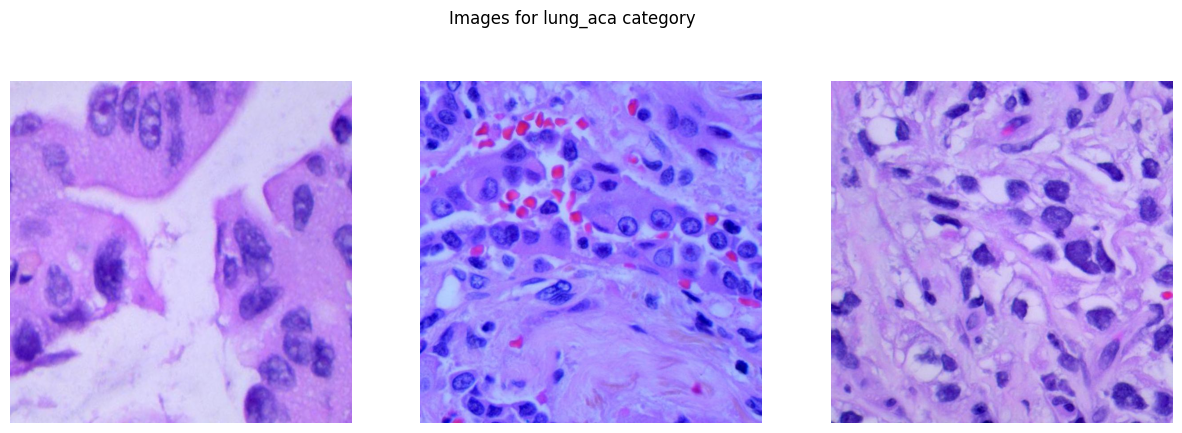

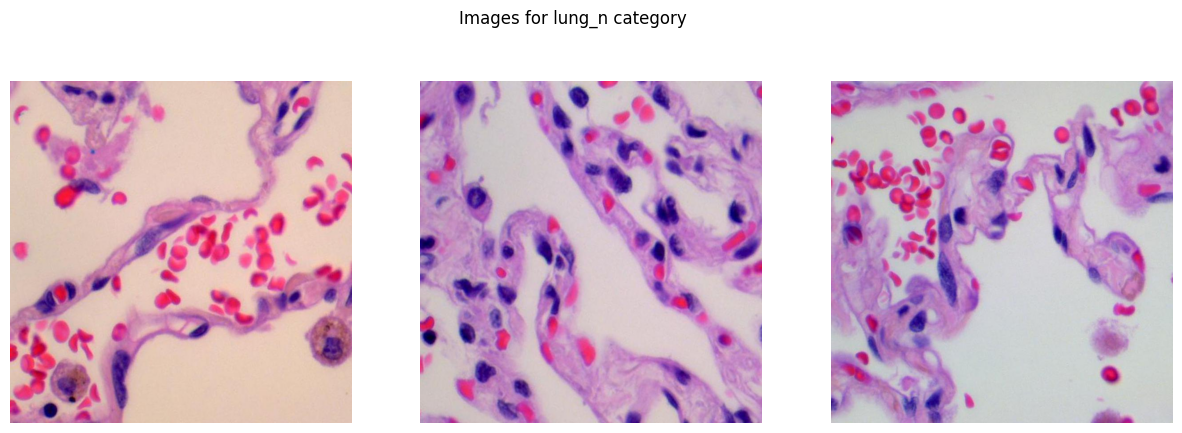

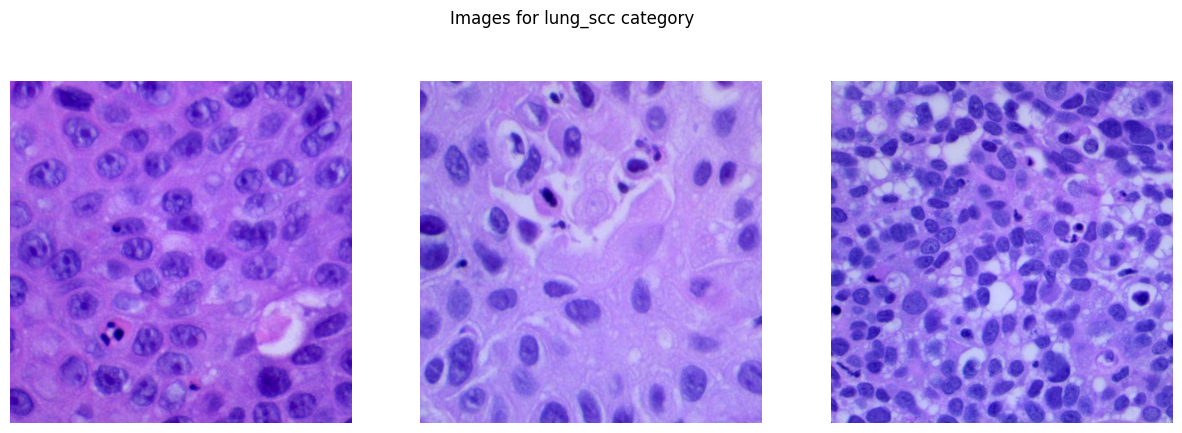

In [5]:
path = 'lung_colon_image_set/lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'Images for {cat} category')

    for i in range(3):
        k = np.random.randint(0, len(images))
        # img = (cv2.imread(f'{image_dir}/{images[k]}', cv2.COLOR_BGR2RGB))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [6]:
IMG_SIZE = 256
EPOCHS = 10
BATCH_SIZE = 64
SEED = 42

# X = []
# Y = []

# for i, cat in enumerate(classes):
#     images = glob.glob(f'{path}/{cat}/*.jpeg')

#     for image in images:
#         img = cv2.imread(image)
#         X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
#         Y.append(i)

train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.2,
    subset='training',
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)
num_classes = len(class_names)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Classes: ['lung_aca', 'lung_n', 'lung_scc']


In [7]:
def normalize(x,y):
    x = tf.cast(x, tf.float32)/255.0
    return x,y

train_ds = (train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
           .prefetch(tf.data.AUTOTUNE))
val_ds = (val_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
           .prefetch(tf.data.AUTOTUNE))

In [8]:
# for i in range(5):
#     print(f"Image {i} shape: {X[i].shape}, dtype: {X[i].dtype}")

In [9]:
# print(X[0].shape)

In [10]:
# X = np.asarray(X)

In [11]:
# X[0].shape

In [12]:
# print(Y)

In [13]:
# one_hot_encoded_Y = pd.get_dummies(Y).astype(int).values

In [14]:
# print(one_hot_encoded_Y)

In [15]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=0.2, random_state=2022)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
def make_model():
    model = keras.models.Sequential([
        # layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        layers.Conv2D(
            filters=32,
            kernel_size = (5,5),
            activation = 'relu',
            input_shape = (IMG_SIZE, IMG_SIZE, 3), #IMG_SIZE = 256
            padding = 'same'
        ),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(
            filters=64,
            kernel_size= (3,3),
            activation = 'relu',
            padding='same'
        ),
        layers.MaxPooling2D(2,2),
    
        layers.Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same'
        ),
        layers.MaxPooling2D(2,2),
    
        # layers.Flatten()
        layers.GlobalAveragePooling2D(), 
        layers.Dense(256, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(3, activation='softmax')
    ])
    return model

# model.summary()

NameError: name 'model' is not defined

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90% so, stopping further training')
            self.mode.stop_training = True

es = EarlyStopping(
    monitor = 'val_loss', 
    restore_best_weights=True
)

ler = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience=2, 
    factor=0.5, 
    verbose=1
)

mc = ModelCheckpoint(
    "best.keras",
    save_best_only=True,
    monitor='val_loss'
)

callbacks = [
    es,            
    mc,            
    myCallback(),  
    ler 
]

In [25]:
lrs = [1e-3, 5e-4, 1e-4]
histories = {}

In [26]:
for lr in lrs:
    model = make_model()
    adam = tf.keras.optimizers.Adam(lr)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    history = model.fit(train_ds, 
                       validation_data = val_ds,
                       epochs = EPOCHS,
                       verbose=1,
                       callbacks=[es, ler,mc, myCallback()]
                                  )

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.8513 - loss: 0.3616 - val_accuracy: 0.6260 - val_loss: 0.9803 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.8955 - loss: 0.2635 - val_accuracy: 0.6470 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9009 - loss: 0.2527 - val_accuracy: 0.6100 - val_loss: 1.2678 - learning_rate: 0.0010
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8669 - loss: 0.3275 - val_accuracy: 0.3213 - val_loss: 1.1173 - learning_rate: 5.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9014 - loss: 0.2435
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
188/188 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9106 - loss: 0.2263 - val_accuracy: 0.5460 - val_loss: 0.9065 - learning_rate: 5.0000e-04
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8497 - los

In [ ]:
plt.figure(figsize=(8,5))
for lr, hist in histories.items():
    plt.plot(hist["val_loss"], label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Different Learning Rates")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_prob = model.predict(val_ds)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy()) 
y_true = np.array(y_true)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=val_ds.class_names))
print(confusion_matrix(y_true, y_pred))